# Image Preprocessing

The purpose of this notebook is to convert the images, given in DICOM format, which is not optimal for feeding to a CNN, to jpg files.

Once this is done, the images will be randomly separated into different files for training, validation, and testing, both with the non-opacity/non-pneumonia (labeled here as 'normal', although the images need not be normal, they just do not have pneumonia) and with the pneumonia subgroup.

For this purpose, the csv dataset is loaded. Then, using a function (`data_split`) that loops twice over sklearn `train_test_split` three dataframes are randomly created, stratifying by Target to mantain the proportion of opacity vs non-opacity in both subsets. Using those subsets, the files are copied to its corresponding subfolders:
    - Train non-opacity.
    - Train opacity.
    
    - Validation non-opacity.
    - Validation opacity.
    
    - Test non-opacity.
    - Test opacity.


- *CXR: Chest X-Ray.*

##  Imports

### Libraries 

In [11]:
# System and file management
import os
import zipfile
import shutil

# General imports
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# sklearn imports
from sklearn.model_selection import train_test_split

# DICOM
import pydicom
from pydicom.filereader import dcmread

### Functions

In [2]:
def subfolder_creator(path):
    """
    This function checks wether a folder exist. In case it does not, it creates it.
    """
    if os.path.exists(path):
        path
    else:
        os.mkdir(path)
        

def data_split(examples, labels, train_frac, random_state=None, stratify=None):
    """
    This function returns two lists of files, one with the normal xrays and another one with the pneumonia xrays, and prints the total number of files in each group.
    Inputs:
        - file_path: the path of the folder containing the dicom images.
        - dataframe: the dataframe over which you want to iterate to separate both classes.
        - dicom (default False): wether the file_path contains DICOM (set to True) or JPG files.
    Outputs:
        - List containing normal X-rays.
        - List containing non-normal/non-pneumonia X-rays.
        - List containing Pnuemonia X-rays.
    """
    assert train_frac >= 0 and train_frac <= 1, "Invalid training set fraction"

    X_train, X_tmp, Y_train, Y_tmp = train_test_split(examples, 
                                                      labels, 
                                                      train_size=train_frac, 
                                                      random_state=random_state,
                                                      stratify=stratify)

    X_val, X_test, Y_val, Y_test   = train_test_split(
                                        X_tmp, Y_tmp, train_size=0.5, random_state=random_state)

    return X_train, X_val, X_test,  Y_train, Y_val, Y_test

        
        
def dcm_to_img(origin_fpath, destination_fpath, PNG=False):
    """
    This function extracts the image information from DICOM (.dcm) files
    and converts it to either .png or .jpg files, saving it in the desired folder
    Inputs:
        - origin_fpath: path where the .dcm files are located.
        - destination_fpath: desired output path of the converted images.
        - PNG: default False. Wether you want the output files in .png (set as True) or .jpg format.
    Outputs:
        - Converted files, either to *.png or *.jpg.
    """
    
    images_path = os.listdir(origin_fpath) # List of files inside origin folder
    
    for n, image in enumerate(images_path):
        ds = pydicom.dcmread(os.path.join(origin_fpath, image))
        pixel_array_numpy = ds.pixel_array
        if PNG == False:
            image = image.replace('.dcm', '.jpg')
        else:
            image = image.replace('.dcm', '.png')
        cv2.imwrite(os.path.join(destination_fpath, image), pixel_array_numpy)
        if n % 1000 == 0:
            print('{} images converted'.format(n)) # Counter for every 1000 images converted
            
            
            

def target_extractor(origin_fpath, dataframe, dicom=False):
    """
    This function returns two lists of files, one with the normal xrays and another one with the pneumonia xrays, and prints the total number of files in each group.
    Inputs:
        - file_path: the path of the folder containing the dicom images.
        - dataframe: the dataframe over which you want to iterate to separate both classes.
        - dicom (default False): wether the file_path contains DICOM (set to True) or JPG files.
    Outputs:
        - List containing non-opacity X-rays.
        - List containing opacity X-rays.
    """
    normalcxr = []; pneumoniacxr = []
    if dicom == True:
        for i in os.listdir(origin_fpath):
            if i in list(dataframe.dcm_file_name.loc[dataframe.target == 1]):
                pneumoniacxr.append(i) 
            elif i in list(dataframe.dcm_file_name.loc[dataframe.target == 0]):
                normalcxr.append(i)
            else:
                pass
            
    if dicom == False:
        for i in os.listdir(origin_fpath):
            if i in list(dataframe.jpg_file_name.loc[dataframe.target == 1]):
                pneumoniacxr.append(i) 
            elif i in list(dataframe.jpg_file_name.loc[dataframe.target == 0]):
                normalcxr.append(i)
            else:
                pass
        
    return (normalcxr, pneumoniacxr)



            
def copy_files(origin_fpath, destination_fpath, file_list):
    """
    This function checks if the directories exists then moves the files whose names are contained 
    in the list to the desired destination directory.
    Inputs:
        - origin_fpath: path of origin of the files.
        - destination_fpath: desired destination path.
        - file_list: the list of names of the files that are to be moved.
    Outputs:
        - No outputs displayed.
    """
    # Check if both the are directories
    if os.path.isdir(origin_fpath) and os.path.isdir(destination_fpath) :
        # Iterate over all the files in a list, that we know are located in the source directory
        for file in file_list:
            # Define the route:
            file_path = os.path.join(origin_fpath, file)
            # Move each file to destination Directory
            shutil.copy(file_path, destination_fpath);
    else:
        print("origin_fpath & destination_fpath should be Directories")
        
        

        
def zip_creator(fname_list, origin_fpath, destination_fpath, file_name='default.zip'):
    """
    This function exports a .zip file containing the files whose names are in a provided list.
    Inputs:
        - fname_list: list containing the names of the files to be compressed.
        - origin_fpath: path where the origin files are located.
        - destination_fpath: path where the created .zip will be exported.
        - file_name: desired name of the .zip file.
    Outputs:
        - .zip file containing the original images.
    """
    compressed = zipfile.ZipFile(os.path.join(destination_fpath, file_name), 'w')
    for file in fname_list:
        img_path = os.path.join(origin_fpath, file)
        compressed.write(img_path)
    compressed.close()

### Paths and constants

In [3]:
PATH = 'data/' # root
CSV_PATH = os.path.join(PATH,'csv') # folder with csv datasets
DICOM_PATH = os.path.join(PATH, 'pool') # folder containing all of the dicom files
JPG_PATH = os.path.join(PATH, 'pool_jpg') # folder containing all the converted jpg files
DESTINATION_PATH = os.path.join(PATH, 'sorted_balanced') # Folder where the train and test subsets will be located

# Train folder
TRAIN_PATH = os.path.join(DESTINATION_PATH, 'train')
TRAIN_NORMAL_PATH = os.path.join(TRAIN_PATH, 'normal')
TRAIN_PNEUMONIA_PATH = os.path.join(TRAIN_PATH, 'pneumonia')

# Validation folder
VAL_PATH = os.path.join(DESTINATION_PATH, 'validation')
VAL_NORMAL_PATH = os.path.join(VAL_PATH, 'normal')
VAL_PNEUMONIA_PATH = os.path.join(VAL_PATH, 'pneumonia')

# Test folder
TEST_PATH = os.path.join(DESTINATION_PATH, 'test')
TEST_NORMAL_PATH = os.path.join(TEST_PATH, 'normal') 
TEST_PNEUMONIA_PATH = os.path.join(TEST_PATH, 'pneumonia') 

### CSV import

The clean csv file created in the previous step is loaded:

In [4]:
labels = pd.read_csv(os.path.join(CSV_PATH,'cxr_information.csv'))
labels.head()

,patient_id,dcm_file_name,jpg_file_name,type,sex,age,view,target,target_3,type_0,type_1,type_2
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg,No Lung Opacity / Not Normal,F,51,PA,0,1,0,1,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.jpg,No Lung Opacity / Not Normal,F,48,PA,0,1,0,1,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,00322d4d-1c29-4943-afc9-b6754be640eb.dcm,00322d4d-1c29-4943-afc9-b6754be640eb.jpg,No Lung Opacity / Not Normal,M,19,AP,0,1,0,1,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.jpg,Normal,M,28,PA,0,0,1,0,0
4,00436515-870c-4b36-a041-de91049b9ab4,00436515-870c-4b36-a041-de91049b9ab4.dcm,00436515-870c-4b36-a041-de91049b9ab4.jpg,Lung Opacity,F,32,AP,1,2,0,0,1


## Dealing with the unbalance 

There is a problem with unbalance in the target variable:

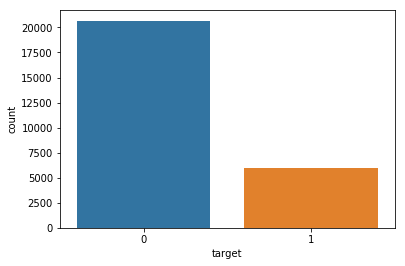

In [5]:
sns.countplot(x = 'target', data = labels)

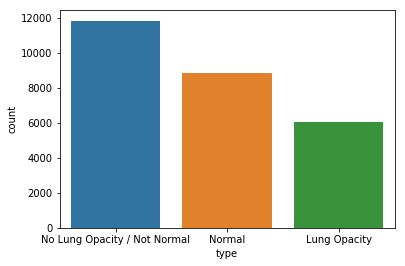

In [6]:
sns.countplot(x = 'type', data = labels)

In [7]:
labels.type.loc[labels.type == 'Lung Opacity'].count()

6012

I decided to do an undersampling method using the 6012 pneumonia CXR and 6012 normal CXR (from the normal group)

In [8]:
labels = labels.loc[labels.type != 'No Lung Opacity / Not Normal']

In [9]:
labels.shape

(14863, 12)

In [13]:
np.random.seed(10)

remove_n = 8851 - 6012
drop_indices = np.random.choice(labels.loc[labels.target_3 == 0].index, remove_n, replace=False)
labels = labels.drop(drop_indices)

In [14]:
labels.shape

(12024, 12)

In [15]:
labels.to_csv(os.path.join(CSV_PATH,'balanced_cxr_information.csv'), index= False)

So we have ended up with a smaller dataset that is more balanced

##  train-validation-test split

In [16]:
X_train, X_val, X_test, y_train, y_val, y_test = data_split(labels.drop(columns = ['target']), labels.target, train_frac=0.7, random_state=20, stratify=labels.target)

/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.to_csv(os.path.join(CSV_PATH,'balanced_train_target_2.csv'), index=False)

In [18]:
val_df = pd.concat([X_val, y_val], axis=1)
val_df.to_csv(os.path.join(CSV_PATH,'balanced_val_target_2.csv'), index=False)

In [19]:
test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv(os.path.join(CSV_PATH,'balanced_test_target_2.csv'), index=False)

### Distribution of Target variable in Train, Validation and Test Subsets

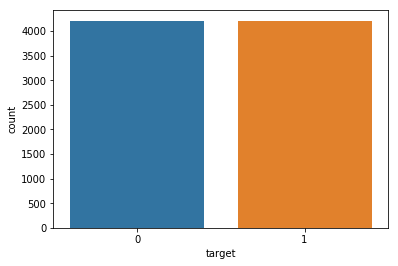

In [20]:
sns.countplot(x = 'target', data = train_df)

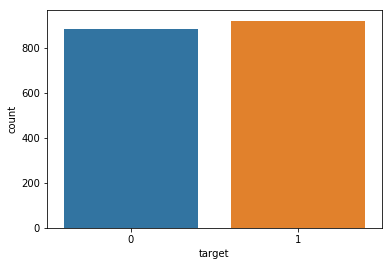

In [21]:
sns.countplot(x = 'target', data = val_df)

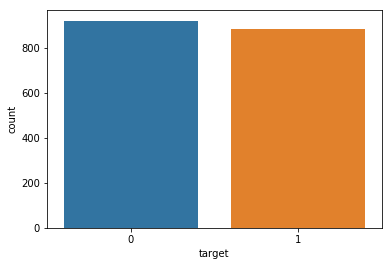

In [22]:
sns.countplot(x = 'target', data = test_df)

We can check that proportions on the three subsets are consistent with the original proportions, and thus, data is quite unbalanced.

## Decompress files

In [23]:
# Uncomment this cell if the files need to be decompressed (first time)
"""
# Creating directory:
subfolder_creator(DICOM_PATH)

# Extracting the dicom files into directory:
local_zip = os.path.join(PATH, 'all_images.zip')
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(DICOM_PATH)
zip_ref.close()
"""

## Convert .dcm files to .jpg

In [24]:
# Uncomment this cell if the files need to be converted (first time)
"""
# Creating directory:
subfolder_creator(JPG_PATH)

# Converting .dcm to .jpg:
dcm_to_img(origin_fpath=DICOM_PATH,
           destination_fpath=JPG_PATH,
           PNG=False)
"""

0 images converted
1000 images converted
2000 images converted
3000 images converted
4000 images converted
5000 images converted
6000 images converted
7000 images converted
8000 images converted
9000 images converted
10000 images converted
11000 images converted
12000 images converted
13000 images converted
14000 images converted
15000 images converted
16000 images converted
17000 images converted
18000 images converted
19000 images converted
20000 images converted
21000 images converted
22000 images converted
23000 images converted
24000 images converted
25000 images converted
26000 images converted


## Separating "Normal" and Pneumonia CXR for each subset

Using the `target_extractor` function defined above, a list containing the names of images with pneumonia and other containing the names of images without pneumonia are created.

A short script is run afterwards to check that the number of total X-Rays is the same as the number of files in desired path.

In [25]:
train_normal_files, train_pneumonia_files = target_extractor(JPG_PATH, train_df)

In [26]:
val_normal_files, val_pneumonia_files = target_extractor(JPG_PATH, val_df)

In [27]:
test_normal_files, test_pneumonia_files = target_extractor(JPG_PATH, test_df)

In [28]:
print('Non-opacity train X-rays:{}\nOpacity train X-rays:{}'.format(len(train_normal_files), 
                                                                    len(train_pneumonia_files)))
      
print('Non-opacity validation X-rays:{}\nOpacity validation X-rays:{}'.format(len(val_normal_files), 
                                                                              len(val_pneumonia_files)))

print('Non-opacity test X-rays:{}\nOpacity test X-rays:{}'.format(len(test_normal_files), 
                                                                  len(test_pneumonia_files)))

total = len((train_normal_files + train_pneumonia_files + val_normal_files + val_pneumonia_files + test_normal_files + test_pneumonia_files))
print('Total files in list: {}'.format(total))


print('======\nTotal files in original path:{}'.format(len(os.listdir(JPG_PATH))))

Non-opacity train X-rays:4208
Opacity train X-rays:4208
Non-opacity validation X-rays:884
Opacity validation X-rays:920
Non-opacity test X-rays:920
Opacity test X-rays:884
Total files in list: 12024
Total files in original path:26684


## Creating sub-folder structure and moving the images to their corresponding subset:

Checking that the subfolders are created, if not, create them:

In [29]:
for folder in [DESTINATION_PATH, 
               TRAIN_PATH, 
               VAL_PATH,
               TEST_PATH, 
               TRAIN_NORMAL_PATH, 
               TRAIN_PNEUMONIA_PATH,
               VAL_NORMAL_PATH,
               VAL_PNEUMONIA_PATH,
               TEST_NORMAL_PATH, 
               TEST_PNEUMONIA_PATH]:
    subfolder_creator(folder)

Looping over the lists and the desired destination files to move files using `move_files` function defined above:

In [31]:
var = [train_normal_files, train_pneumonia_files, val_normal_files, val_pneumonia_files, test_normal_files, test_pneumonia_files]
path = [TRAIN_NORMAL_PATH, TRAIN_PNEUMONIA_PATH, VAL_NORMAL_PATH, VAL_PNEUMONIA_PATH, TEST_NORMAL_PATH, TEST_PNEUMONIA_PATH]

for a,b in zip(var,path):
    copy_files(origin_fpath=JPG_PATH,
               destination_fpath=b, 
               file_list=a)

## Conclusion 

The result of runing this notebook should be the creation of a **sorted** folder containing three subfolders, **train**, **validation** and **test** each one containing two subclasses of images, *normal* and *pneumonia*.